In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from typing import Tuple

print("Cuda available :", torch.cuda.is_available())
print("cuda version : ", torch.backends.cudnn.version())
print("No of GPU : ", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i} Name: ", torch.cuda.get_device_name(i))

Cuda available : True
cuda version :  8907
No of GPU :  1
Device 0 Name:  NVIDIA GeForce GTX 1650 with Max-Q Design


In [2]:
# Get image inputs and preprocess
def preprocess_images(image_path1:str, image_path2:str, height_width:int=256) -> Tuple[torch.Tensor, torch.Tensor]:
    transform = transforms.Compose([
        transforms.Resize((height_width, height_width)),
        transforms.ToTensor()
    ])
    image1 = Image.open(image_path1).convert("RGB")
    image2 = Image.open(image_path2).convert("RGB")
    print("Shape of Image 1 : ", image1.size)
    print("Shape of Image 2 : ", image2.size)
    image1 = transform(image1).unsqueeze(0).to('cuda')
    image2 = transform(image2).unsqueeze(0).to('cuda')
    print("Shape of Reshaped Image 1 : ", image1.shape)
    print("Shape of Reshaped Image 2 : ", image2.shape)
    return image1, image2

In [3]:
def show_image(image:torch.Tensor) -> None:
    image_np = image.squeeze().cpu().detach().numpy()
    image_np = image_np.transpose(1, 2, 0)  # (C, W, H) -> (W, H, C)
    plt.imshow(image_np)
    plt.show()

Shape of Image 1 :  (500, 500)
Shape of Image 2 :  (324, 500)
Shape of Reshaped Image 1 :  torch.Size([1, 3, 256, 256])
Shape of Reshaped Image 2 :  torch.Size([1, 3, 256, 256])


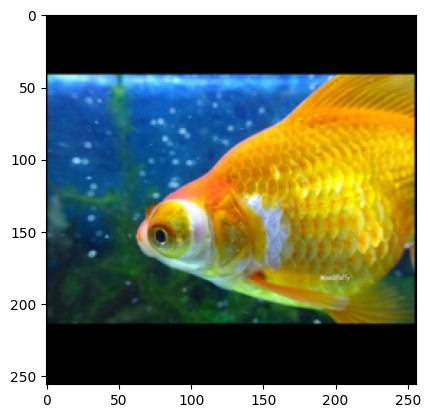

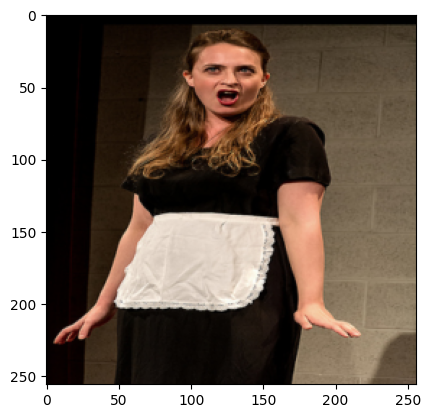

In [4]:
image_path1 = './original_images/fuse1.JPEG'  
image_path2 = './original_images/fuse2.JPEG'  
img1, img2 = preprocess_images(image_path1, image_path2)
show_image(img1)
show_image(img2)

In [5]:
class FuseModel(nn.Module):
    def __init__(self):
        super(FuseModel, self).__init__()

        # Downsampling
        self.down_reflection_pad = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=0),  
            nn.InstanceNorm2d(64),
            nn.ReLU()
        )
        self.down_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU()
        )
        self.down_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU()
        )
        self.down_resnet_block1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        )

        # Upsampling
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(256),  
            nn.ReLU()
        )
        self.up_deconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU()
        )
        self.up_deconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU()
        )
        self.up_resnet_block1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        )
        self.up_reflection_pad = nn.Sequential(
            nn.ReflectionPad2d(3), 
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=0),  # 7x7 Conv with no additional padding
            nn.InstanceNorm2d(3),  
            nn.Tanh() 
        )

    def forward(self, x1:torch.Tensor, x2:torch.Tensor) -> torch.Tensor:
        print("Input shape : ", x1.shape, "and", x2.shape)

        # Downsampling
        x1 = self.down_reflection_pad(x1)  
        x2 = self.down_reflection_pad(x2)  
        # print("Shape after Down 1 layer : ", x1.shape, "and", x2.shape)
        x1 = self.down_conv1(x1) 
        x2 = self.down_conv1(x2) 
        # print("Shape after Down 2 layer : ", x1.shape, "and", x2.shape)          
        x1 = self.down_conv2(x1)  
        x2 = self.down_conv2(x2)  
        # print("Shape after Down 3 layer : ", x1.shape, "and", x2.shape)         
        for i in range(9):
            x1 = self.down_resnet_block1(x1)  
            x2 = self.down_resnet_block1(x2)  
        # print("Shape after Down resnet layers : ", x1.shape, "and", x2.shape)
        
        
        # Concatenation
        x = torch.cat((x1, x2), dim=1)
        # print("Shape after Concatenation : ", x.shape)

        # Upsampling
        x = self.up_conv1(x)
        # print("Shape after Up 1 layer : ", x.shape)
        for i in range(1):
            x = self.up_resnet_block1(x)
        for i in range(9):
            x = self.up_resnet_block1(x)
        for i in range(1):
            x = self.up_resnet_block1(x)
        for i in range(9):
            x = self.up_resnet_block1(x)
        # print("Shape after Up resnet layers : ", x.shape)
        x = self.up_deconv1(x)
        # print("Shape after Up 2 layer : ", x.shape)    
        x = self.up_deconv2(x)
        # print("Shape after Up 3 layer : ", x.shape)     
        x = self.up_reflection_pad(x)
        # print("===Output shape : ", x.shape)
        
        return x
    
# fuse_model = FuseModel().to("cuda")

In [6]:
# fused_image = fuse_model(img1, img2)
# detached_fused_image = fused_image.squeeze().cpu().detach().numpy()
# detached_fused_image = detached_fused_image.transpose(1, 2, 0)
# print(detached_fused_image.shape)
# plt.imshow(detached_fused_image)
# plt.show()

In [7]:
class DefuseModel(nn.Module):
    def __init__(self):
        super(DefuseModel, self).__init__()

        # Downsampling
        self.down_reflection_pad = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=0),  
            nn.InstanceNorm2d(64),
            nn.ReLU()
        )
        self.down_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU()
        )
        self.down_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU()
        )
        self.down_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.ReLU()
        )
        self.down_resnet_block1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        )

        # Upsampling
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(256),  
            nn.ReLU()
        )
        self.up_deconv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU()
        )
        self.up_deconv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU()
        )
        self.up_resnet_block1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        )
        self.up_reflection_pad = nn.Sequential(
            nn.ReflectionPad2d(3), 
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=0),  # 7x7 Conv with no additional padding
            nn.InstanceNorm2d(3),  
            nn.Tanh() 
        )

    def forward(self, x:torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # print("Input shape : ", x.shape)

        # Downsampling
        x = self.down_reflection_pad(x)   
        # print("Shape after Down 1 layer : ", x.shape)
        x = self.down_conv1(x) 
        # print("Shape after Down 2 layer : ", x.shape)          
        x = self.down_conv2(x)  
        # print("Shape after Down 3 layer : ", x.shape)         
        for i in range(1):
            x = self.down_resnet_block1(x)  
        for i in range(9):
            x = self.down_resnet_block1(x)  
        for i in range(1):
            x = self.down_resnet_block1(x)  
        for i in range(9):
            x = self.down_resnet_block1(x)  
        # print("Shape after Down resnet layers : ", x.shape)
        x = self.down_conv3(x)  
        # print("Shape after Down 4 layer : ", x.shape) 
        
        
        # Defusion
        x1, x2 = torch.split(x, 256, dim=1)
        # print("Shape after Defusion : ", x1.shape, "and", x2.shape)

        # Upsampling
        # x = self.up_conv1(x)
        # print("Shape after Up 1 layer : ", x.shape)
        # for i in range(1):
        #     x = self.up_resnet_block1(x)
        for i in range(9):
            x1 = self.up_resnet_block1(x1)
            x2 = self.up_resnet_block1(x2)
        for i in range(1):
            x1 = self.up_resnet_block1(x1)
            x2 = self.up_resnet_block1(x2)
        # print("Shape after Resnet : ", x1.shape, "and", x2.shape)
        # for i in range(9):
        #     x = self.up_resnet_block1(x)
        # print("Shape after Up resnet layers : ", x.shape)
        x1 = self.up_deconv1(x1)
        x2 = self.up_deconv1(x2)
        # print("Shape after Up 2 layer : ", x1.shape, "and", x2.shape)    
        x1 = self.up_deconv2(x1)
        x2 = self.up_deconv2(x2)
        # print("Shape after Up 3 layer : ", x1.shape, "and", x2.shape)     
        x1 = self.up_reflection_pad(x1)
        x2 = self.up_reflection_pad(x2)
        # print("===Output shape : ", x1.shape, "and", x2.shape)
        
        return x1, x2
    
# defuse_model = DefuseModel().to("cuda")

In [8]:
# recovered_secret_img_1, recovered_secret_img_2 = defuse_model(fused_image)
# detached_recovered_secret_img_1 = recovered_secret_img_1.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
# detached_recovered_secret_img_2 = recovered_secret_img_2.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
# plt.imshow(detached_recovered_secret_img_1)
# plt.show()
# plt.imshow(detached_recovered_secret_img_2)
# plt.show()

In [9]:
# fused_image = fuse_model(img1, img2)
# detached_fused_image = fused_image.squeeze().cpu().detach().numpy()
# detached_fused_image = detached_fused_image.transpose(1, 2, 0)
# print(detached_fused_image.shape)
# plt.imshow(detached_fused_image)
# plt.show()

In [10]:
def gaussian(window_size, sigma):
    gauss = torch.tensor([
        torch.exp(torch.tensor(-(x - window_size // 2)**2 / float(2 * sigma**2))) for x in range(window_size)
    ])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, window_size=11, channel=1, size_average=True):
    window = create_window(window_size, channel).to(img1.device)
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

In [11]:
# plt.imshow(img1)

In [12]:
import torch.optim as optim
from tqdm import tqdm

train_fuse_model_1 = FuseModel().to("cuda")
train_defuse_model_1 = DefuseModel().to("cuda")
train_fuse_model_1_optimizer = optim.Adam(list(train_fuse_model_1.parameters()), lr = 0.01, betas = (0.5, 0.999))
train_defuse_model_1_optimizer = optim.Adam(list(train_defuse_model_1.parameters()), lr = 0.01, betas = (0.5, 0.999))

train_fuse_model_1_scaler = torch.cuda.amp.GradScaler()
train_defuse_model_1_scaler = torch.cuda.amp.GradScaler()

EPOCHS = 2
lambda1 = 1.0
lambda2 = 1.0
lambda3 = 1.0

L1_loss = nn.L1Loss()
MSE_loss = nn.MSELoss()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    # reconstruction_loss_1 = torch.tensor(0.0, device="cuda")
    # reconstruction_loss_2 = torch.tensor(0.0, device="cuda")
    # ssim_loss = torch.tensor(0.0, device="cuda")
    # psnr_loss = torch.tensor(0.0, device="cuda")
    f_img = train_fuse_model_1(img1,img2)
    df_img1, df_img2 = train_defuse_model_1(f_img)

    with torch.cuda.amp.autocast():
        reconstruction_loss_1 = (MSE_loss(img1, torch.ones_like(df_img1)) + MSE_loss(img2, torch.ones_like(df_img2))) /2
        # reconstruction_loss_1 = (F.mse_loss(img1, df_img1) + F.mse_loss(img2, df_img2)) / 2
        # ssim_loss += ((1-ssim(img1, df_img1)) + (1-ssim(img2, df_img2))) / 2
        # reconstruction_loss += (-psnr(img1, df_img1) + -psnr(img2, df_img2)) / 2
        # total_loss = lambda1*reconstruction_loss + lambda2*ssim_loss + lambda3*psnr_loss

    train_fuse_model_1.train()
    train_fuse_model_1_optimizer.zero_grad()
    train_fuse_model_1_scaler.scale(reconstruction_loss_1).backward()
    train_fuse_model_1_scaler.step(train_fuse_model_1_optimizer)
    train_fuse_model_1_scaler.update()

    with torch.cuda.amp.autocast():
        reconstruction_loss_2 = (MSE_loss(img1, torch.ones_like(df_img1)) + MSE_loss(img2, torch.ones_like(df_img2))) /2
    train_defuse_model_1.train()
    train_defuse_model_1_optimizer.zero_grad()
    train_defuse_model_1_scaler.scale(reconstruction_loss_2).backward()
    train_defuse_model_1_scaler.step(train_defuse_model_1_optimizer)
    train_defuse_model_1_scaler.update()

    del f_img, df_img1, df_img2, reconstruction_loss_1, reconstruction_loss_2
    torch.cuda.empty_cache()



Epoch 1/2
Input shape :  torch.Size([1, 3, 256, 256]) and torch.Size([1, 3, 256, 256])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
import torch.optim as optim
from tqdm import tqdm

train_fuse_model_1 = FuseModel().to("cuda")
train_defuse_model_1 = DefuseModel().to("cuda")
train_fuse_model_1_optimizer = optim.Adam(list(train_fuse_model_1.parameters()), lr = 0.01, betas = (0.5, 0.999))
train_defuse_model_1_optimizer = optim.Adam(list(train_defuse_model_1.parameters()), lr = 0.01, betas = (0.5, 0.999))

train_fuse_model_1_scaler = torch.cuda.amp.GradScaler()
train_defuse_model_1_scaler = torch.cuda.amp.GradScaler()

EPOCHS = 2
lambda1 = 1.0
lambda2 = 1.0
lambda3 = 1.0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    # reconstruction_loss_1 = torch.tensor(0.0, device="cuda")
    # reconstruction_loss_2 = torch.tensor(0.0, device="cuda")
    # ssim_loss = torch.tensor(0.0, device="cuda")
    # psnr_loss = torch.tensor(0.0, device="cuda")
    f_img = train_fuse_model_1(img1,img2)
    df_img1, df_img2 = train_defuse_model_1(f_img)

    with torch.cuda.amp.autocast():
        reconstruction_loss_1 = (F.mse_loss(img1, df_img1) + F.mse_loss(img2, df_img2)) / 2
        # ssim_loss += ((1-ssim(img1, df_img1)) + (1-ssim(img2, df_img2))) / 2
        # reconstruction_loss += (-psnr(img1, df_img1) + -psnr(img2, df_img2)) / 2
        # total_loss = lambda1*reconstruction_loss + lambda2*ssim_loss + lambda3*psnr_loss

    train_fuse_model_1.train()
    train_fuse_model_1_optimizer.zero_grad()
    train_fuse_model_1_scaler.scale(reconstruction_loss_1).backward(retain_graph=True)
    train_fuse_model_1_scaler.step(train_fuse_model_1_optimizer)
    train_fuse_model_1_scaler.update()

    with torch.cuda.amp.autocast():
        reconstruction_loss_2 = (F.mse_loss(img1, df_img1) + F.mse_loss(img2, df_img2)) / 2
    train_defuse_model_1.train()
    train_defuse_model_1_optimizer.zero_grad()
    train_defuse_model_1_scaler.scale(reconstruction_loss_2).backward()
    train_defuse_model_1_scaler.step(train_defuse_model_1_optimizer)
    train_defuse_model_1_scaler.update()

    del f_img, df_img1, df_img2, reconstruction_loss_1, reconstruction_loss_2
    torch.cuda.empty_cache()



OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 